In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import regex as re
import os
from deep_translator import GoogleTranslator

In [ ]:
# settings
load_from_file = True
save_to_file = True
use_means = True
use_boxplot = False

In [ ]:
import wikipediaapi
import nltk


def process_article(article_title, language, subpage):
    wiki = wikipediaapi.Wikipedia(
        "FramingAnalysis (riedl.manuel.privat@gmail.com)",
        language,
        extract_format=wikipediaapi.ExtractFormat.WIKI,
    )
    print(f"Processing: {article_title}\n" + f"\tlanguage:".ljust(20) + language)
    page = wiki.page(article_title)
    article = page.text
    if language == "en":
        article = re.split(r"\nSee also\n", article)[0]
    if language == "de":
        print(f"\ttranslation:".ljust(20) + f"{language} - en")
        article = re.split(r"\nLiteratur\n", article)[0]
        sentences = nltk.tokenize.sent_tokenize(article)
        article = ""
        for sentence in sentences:
            translation = GoogleTranslator(source="de", target="en").translate(sentence)
            article += str(translation)
    if subpage:
        links = page.links
        for title in sorted(links.keys()):
            print("%s: %s" % (title, links[title]))

    return article, page


def get_articles(article_titles, language="en", save=True, sub_pages=False):
    articles = []
    for article_title in article_titles:
        article, page = process_article(article_title, language, sub_pages)
        articles.append(article)
        if save:
            with open(
                "articles/" + article_title + "_" + language + ".txt",
                "w",
                encoding="utf8",
            ) as file:
                file.write(article)
                print(f"\tsaved:".ljust(20) + f"{article_title}_{language}.txt")
    return articles

In [ ]:
from framefinder import framedimensions

dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"),
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]
base_model = "all-mpnet-base-v2"
framing_dimensions = framedimensions.FramingDimensions(
    base_model, dimensions, pole_names
)

In [ ]:
import requests
import nltk
# nltk.download('punkt') # need to download punkt once


def read_files(filenames):
    files = []
    for file_name in filenames:
        with open("articles/" + file_name, "r", encoding="utf8") as file:
            files.append(file.read())
    return files


def clean_string(
    text, remove_headers=True, remove_enumerations=True
):  # ? might not work for all articles, need to test
    text = re.split(r"==See also==", text)[0]  # remove everything after "See also"
    text = re.sub(
        r"\{\{Asof\|(\d{4})\|(\d{1,2})\}\}", r"as of \2/\1", text
    )  # replace {{Asof|YYYY|MM}} with as of MM/YYYY
    text = re.sub(r"\{\{.*}}", "", text)  # remove {{}}
    text = re.sub(r"&lt;!--.*?-->", "", text)  # remove <!--...-->
    text = re.sub(r"&lt.*--", "", text)  # remove &lt;!--
    text = re.sub(r"-->", "", text)  # remove -->
    if remove_enumerations:
        text = re.sub(r"\n\*.*", "\n", text)
    else:
        text = re.sub(r"\n\* ", "\n", text)  # remove enumeration symbol *
    text = re.sub(r"\n#", "\n", text)  # remove enumeration symbol #
    text = re.sub(r"&lt;ref.*?&lt;/ref>", "", text)  # remove <ref>...</ref>
    text = re.sub(r"&lt;ref.*/>", "", text)  # remove <ref ... />
    if remove_headers:
        text = re.sub(
            r"==+.*==+\n", "", text
        )  # remove lines containing ==, ===, ====, ...
    else:
        text = re.sub(r"==+", "", text)  # remove ==, ===, ====, ...
    text = re.sub(r"'+", "", text)  # remove ''', '''', ...
    text = re.sub(r"\xa0", " ", text)  # replace non-breaking space with space
    text = re.sub(
        r"\[\[File:(?:\[\[[^\]]*?\]\]|.)*?\]\]", "", text
    )  # remove [[File:...]]
    text = re.sub(
        r"\[\[[^\|\]]*\|([^\]]+)\]\]", r"[[\1]]", text
    )  # replace [[left|right]] with [right]
    text = text.replace(r"[[", "").replace("]]", "")  # remove [[ and ]]
    text = re.sub(
        r"\{\|(?:(?:\{\|(?:(?:\{\|(?:[^{}])*\|\})|(?:[^{}]))*\|\})|(?:[^{}]))*\|\}",
        "",
        text,
    )  # replace nested {| * |}
    text = re.sub(r"\{\{(?:\n|.)*?\}\}", "", text)  # replace {{ * }}
    text = re.sub(r"mini\|.*\|", "", text)
    text = re.sub(r"mini\|", "", text)
    text = re.sub(r":\* .*ISBN.*", "", text)  # remove reverence books
    text = re.sub(r"Kategorie:.*", "", text)  # remove reverence books
    text = re.sub(r"\n+", "\n", text)  # replace multiple newlines with one
    return text


def extract_source(text):
    text = re.split(r"<textarea[^>]*>", text)[1]
    return re.split(r"</textarea>", text)[0]


def fetch_wiki_articles(
    articles, language="en"
):  # ? might not work for all articles, need to test
    article_texts = []
    for article in articles:
        response = requests.get(
            f"https://{language}.wikipedia.org/w/index.php?title={article}&action=edit"
        )
        text = extract_source(response.text)
        article_texts.append(clean_string(text))
    return article_texts


def tokenize_articles(articles):
    tokenized_articles = []
    for article in articles:
        tokenized_articles.append(nltk.sent_tokenize(article))
    return tokenized_articles


def german_article(articles):
    translated_articles = []
    for article in articles:
        sentences = nltk.tokenize.sent_tokenize(article)
        text_en = ""
        for sentence in sentences:
            translation = GoogleTranslator(source="de", target="en").translate(sentence)
            text_en += str(translation)
        translated_articles.append(text_en)
    return translated_articles


def store_articles(articles, file_names):
    for i in range(len(articles)):
        with open("articles/" + file_names[i], "w", encoding="utf8") as file:
            file.write(articles[i])

In [42]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def visualize_boxplot(data_df, quantiles_25_df=None, quantiles_75_df=None):
    labels_right, labels_left = zip(*pole_names)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.boxplot(data_df, vert=False)
    if quantiles_25_df is not None:
        plt.boxplot(quantiles_25_df, vert=False)
    if quantiles_75_df is not None:
        plt.boxplot(quantiles_75_df, vert=False)
    plt.axvline(0)
    plt.gca().invert_yaxis()
    axi = ax.twinx()
    axi.set_ylim(ax.get_ylim())
    if quantiles_25_df is None and quantiles_75_df is None:
        axi.set_yticks(ax.get_yticks(), labels=labels_right)
        ax.set_yticks(ax.get_yticks(), labels=labels_left)
    plt.setp(ax.lines, markersize=0)  # Disables markers on left axis
    plt.setp(axi.lines, markersize=0)  # Disables markers on right axis
    plt.tight_layout()
    return fig

def compare_plots(dfs, titles, colors=None, intens=True):
    labels_right, labels_left = zip(*pole_names)
    labels_right = labels_right[::-1]
    means = [df.mean() for df in dfs]
    intens = [(df.var().fillna(0)+0.001)*(50_000 if intens else 10_000) for df in dfs]
    if colors is None:
        colors = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS) + list(mcolors.CSS4_COLORS)
    legend_entries = [mpatches.Patch(color=colors[0], label=titles[0])]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.scatter(x=means[0], y=labels_left, s=intens[0], c=colors[0])
    plt.axvline(0)
    plt.gca().invert_yaxis()
    ax.twinx().set_yticks(ax.get_yticks(), labels=labels_right)
    fig.axes[0].set_axisbelow(True)
    fig.axes[0].yaxis.grid(color="gray", linestyle="dashed")
    plt.xlim(-.2, .2) # ! arbitrary range
    for i in range(1, len(dfs)):
        legend_entries.append(mpatches.Patch(color=colors[i], label=titles[i]))
        plt.scatter(x=means[i], y=labels_left, s=intens[i], c=colors[i])

    plt.gcf().set_size_inches(10, 7)
    plt.tight_layout()
    plt.legend(handles=legend_entries)
    return fig

In [ ]:
categories = {
    "Abortion": {
        "article_titles": [
            "Anti-abortion_movements",
            "Abortion-rights_movements",
            "Roe_v._Wade",
            "Fetal_rights",
            "Abortion_debate",
            "Abortion_law",
            "United_States_abortion-rights_movement",
            "Abortion_in_the_United_States",
            "United_States_anti-abortion_movement",
            "Heartbeat_bill",
            "March_for_Life_(Washington,_D.C.)",
            "Religion_and_abortion",
        ],
    },
     "Climate change": {
        "article_titles": [
            "Effects_of_climate_change",
            "Climate_change_denial",
            "Climate_apocalypse",
            "Public_opinion_on_climate_change",
            "Media_coverage_of_climate_change",
            "Causes_of_climate_change",
            "CO2_is_Green",
            "Merchants_of_Doubt",
            "Psychology_of_climate_change_denial",
        ]
    },
    "Vaccination": {
        "article_titles": [
            "Anti-vaccine_activism",
            "Embolic_and_thrombotic_events_after_COVID-19_vaccination",
            "Vaccine_adverse_event",
            "Vaccine_hesitancy",
            "Anti-vaccine_activism",
            "COVID-19_vaccine_misinformation_and_hesitancy",
            "Vaccine_misinformation",
            "Vaccination_policy",
            "COVID-19_vaccine_hesitancy_in_the_United_States",
            "Thiomersal_and_vaccines",
        ],
    },
    "Israel": {
        "article_titles": [
            "Zionism",
            "War_crimes_in_the_Israel–Hamas_war",
            "2023_Hamas-led_attack_on_Israel",
            "Israel–Hamas_war_hostage_crisis",
            "Israeli–Palestinian_conflict",
            "Hamas",
            "Israeli_invasion_of_the_Gaza_Strip_(2023–present)",
            "Gaza–Israel_conflict",
            "Israel–Hamas_war",
            "Racism_in_Israel",
            "Palestinian_enclaves",
            "Hafrada",
            "Racism_in_the_State_of_Palestine",
            "Israeli_West_Bank_barrier",
            "Israel_and_apartheid",
        ],
    },
}

In [ ]:
# fetch articles directly from wikipedia or use the ones in the articles folder

# articles = fetch_wiki_articles(article_titles,language="de")
# articles = [clean_string(article) for article in read_files(article_titles)]
# articles = german_article(articles)
# store_articles(articles, article_titles)
# articles = tokenize_articles(articles)
# get_articles(["Sahara"],language = "de")
os.makedirs("articles", exist_ok=True)
for category in categories:
    articles = get_articles(categories[category]["article_titles"])
    articles = tokenize_articles(articles)
    categories[category]["articles"] = articles

In [ ]:
for category in categories:
    article_titles = categories[category]["article_titles"]
    plot_folder = "plots/" + category + "/"
    data_folder = "data/" + category + "/"
    os.makedirs(data_folder + "frame_dimensions", exist_ok=True)
    os.makedirs(plot_folder + "frame_dimensions", exist_ok=True)
    dfs = []
    for i in range(len(article_titles)):
        if load_from_file:
            dimensions_df = pd.read_csv(data_folder + "frame_dimensions/" + article_titles[i] + ".csv", header=[0, 1])
            dimensions_df = dimensions_df.drop(columns=dimensions_df.columns[0])
        else:
            articles = categories[category]["articles"]
            dimensions = framing_dimensions(articles[i])
            dimensions_df = pd.DataFrame(dimensions)
            if save_to_file:
                dimensions_df.to_csv(data_folder + "frame_dimensions/" + article_titles[i] + ".csv", index=False)
        dfs.append(dimensions_df)
        g = visualize_boxplot(dimensions_df) if use_boxplot else framing_dimensions.visualize(dimensions_df)
        # todo alternative: aggregate dimensions of all senctences of all articles and 
        # plot with boxplot + normalization by article length?
        g.axes[0].set_axisbelow(True)
        g.axes[0].yaxis.grid(color="gray", linestyle="dashed")
        plt.xlim(-.2, .2) # ! arbitrary range
        plt.title('Frame Dimensions for "' + article_titles[i] + '"')
        plt.gcf().set_size_inches(10, 7)
        if save_to_file:
            plt.savefig(plot_folder + "frame_dimensions/" + article_titles[i] + ("_boxplot" if use_boxplot else "") +".png")
        plt.show()
    categories[category]["dfs"] = dfs

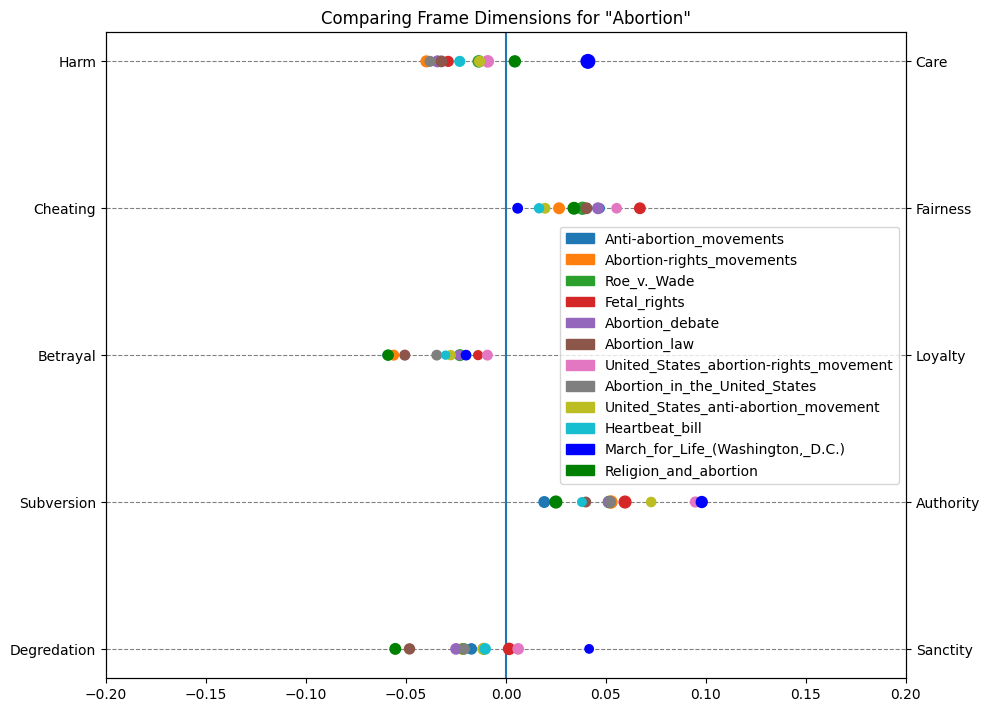

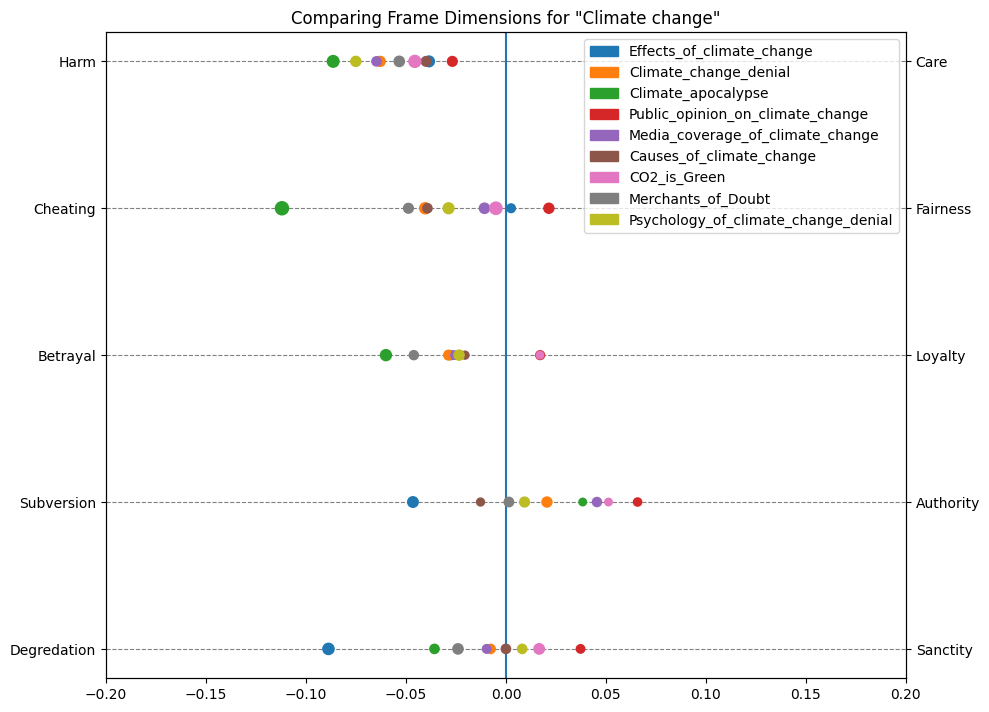

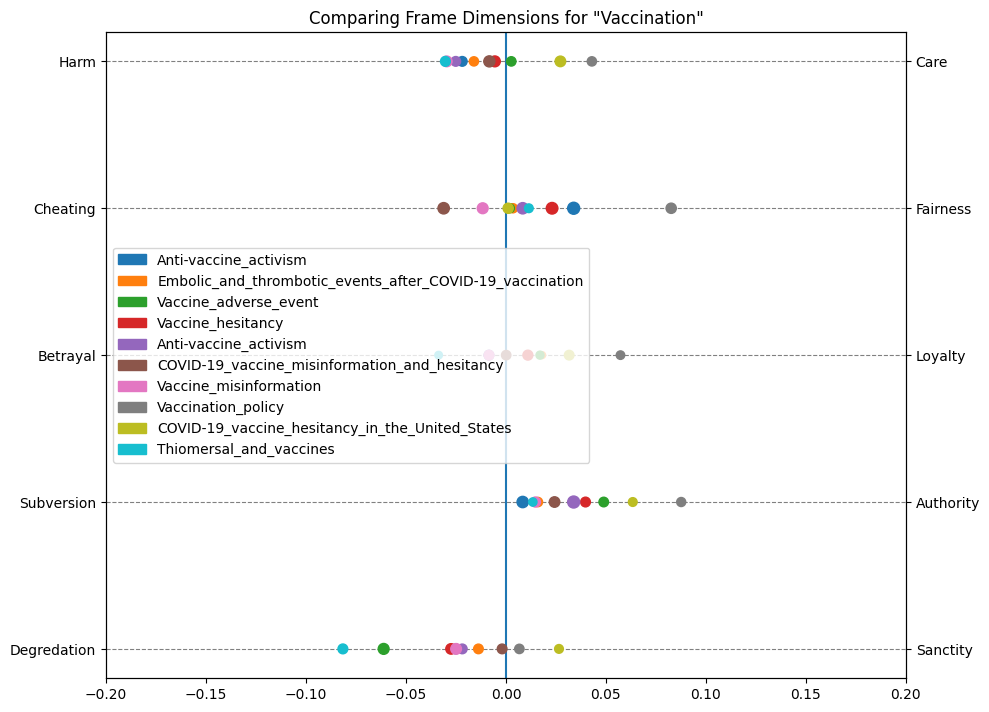

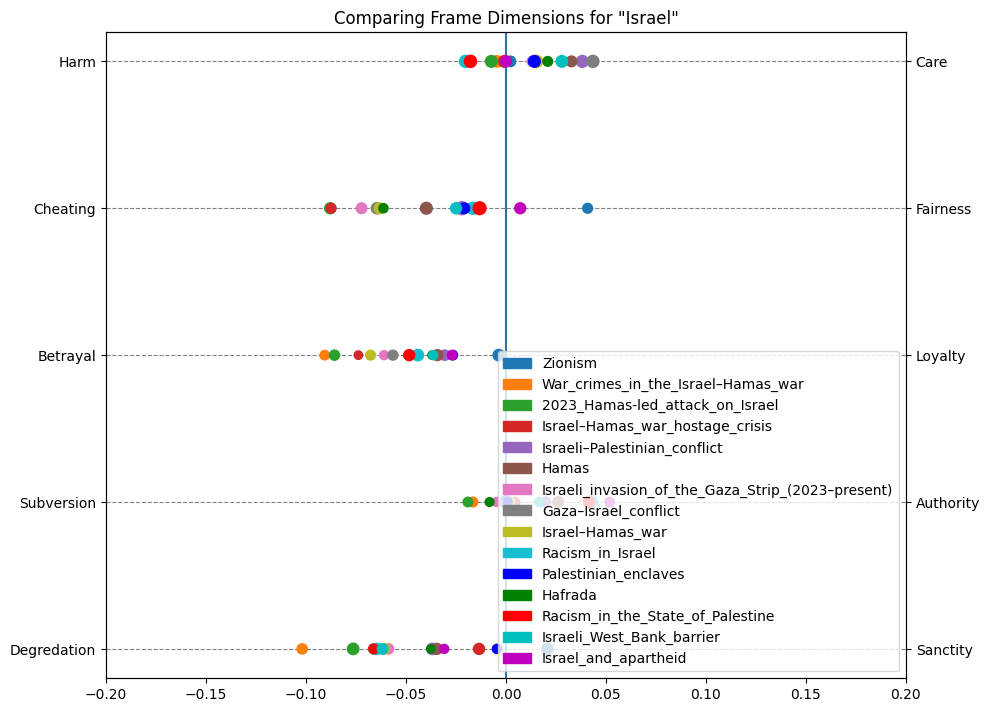

In [43]:
for category in categories:
    article_titles = categories[category]["article_titles"]
    plot_folder = "plots/" + category + "/"
    g = compare_plots(categories[category]["dfs"], categories[category]["article_titles"], intens=False)
    plt.title(f'Comparing Frame Dimensions for "{category}"')
    if save_to_file:
        plt.savefig(plot_folder + "frame_dimensions/comparison.png")
    plt.show()

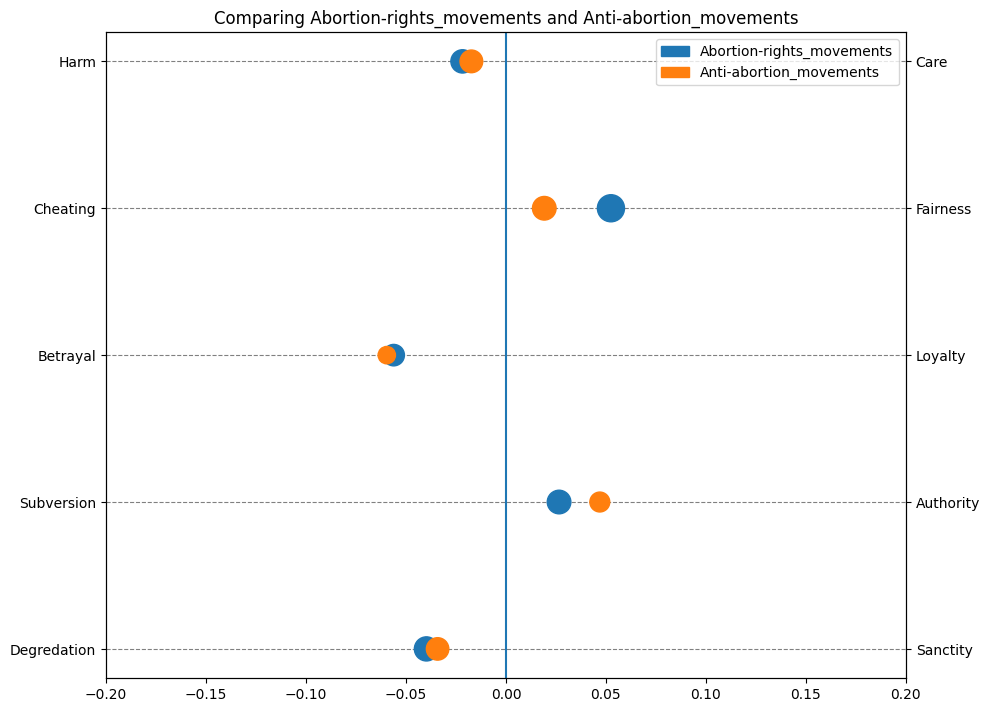

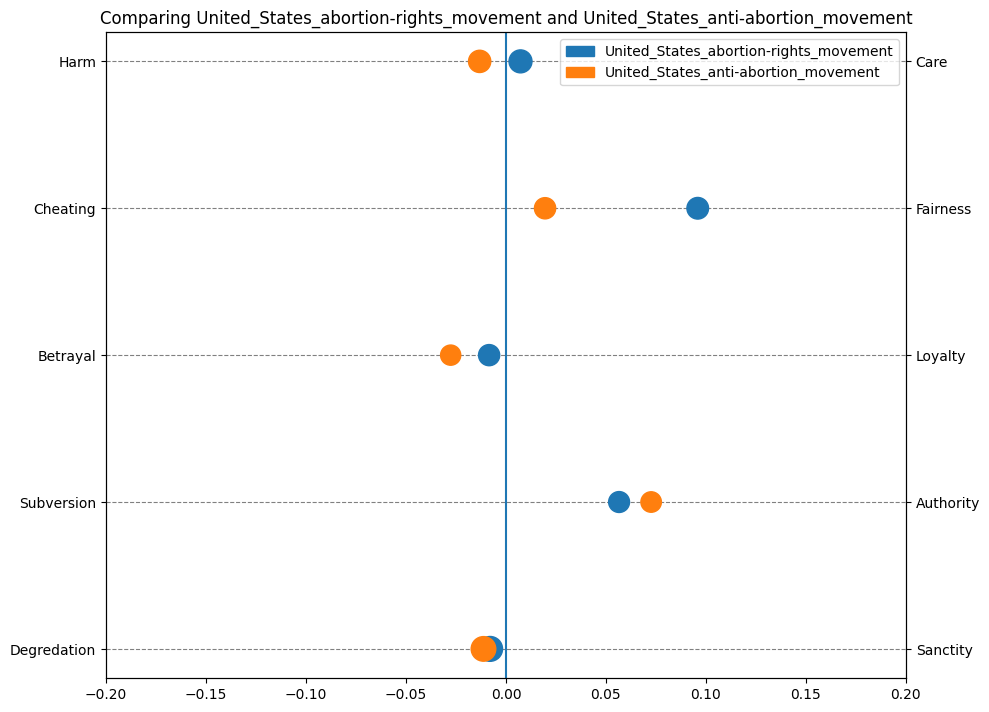

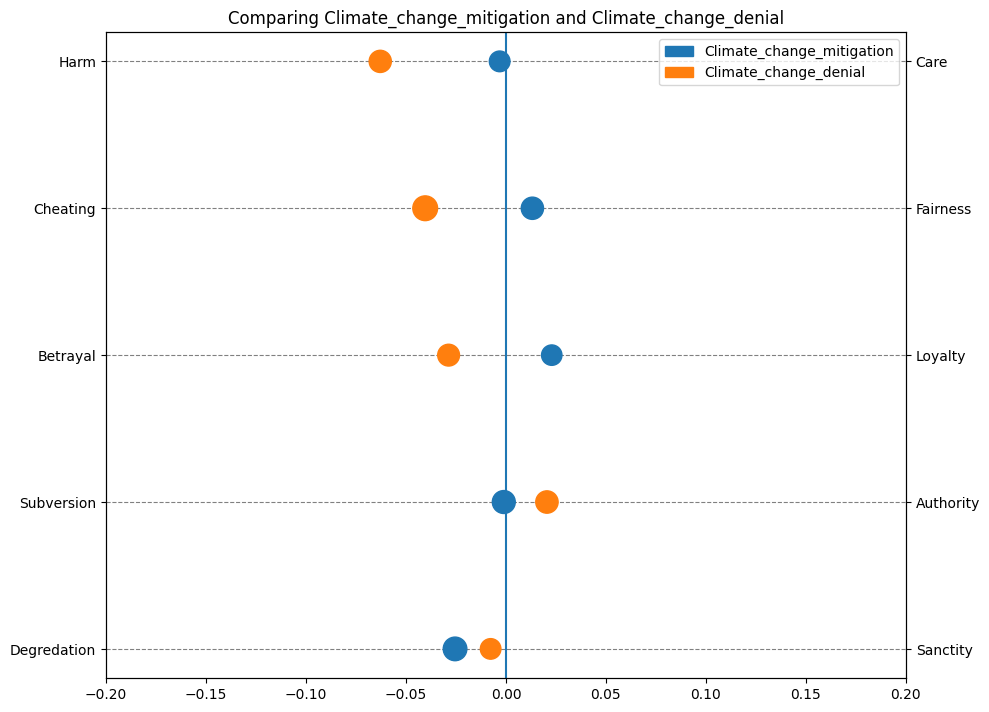

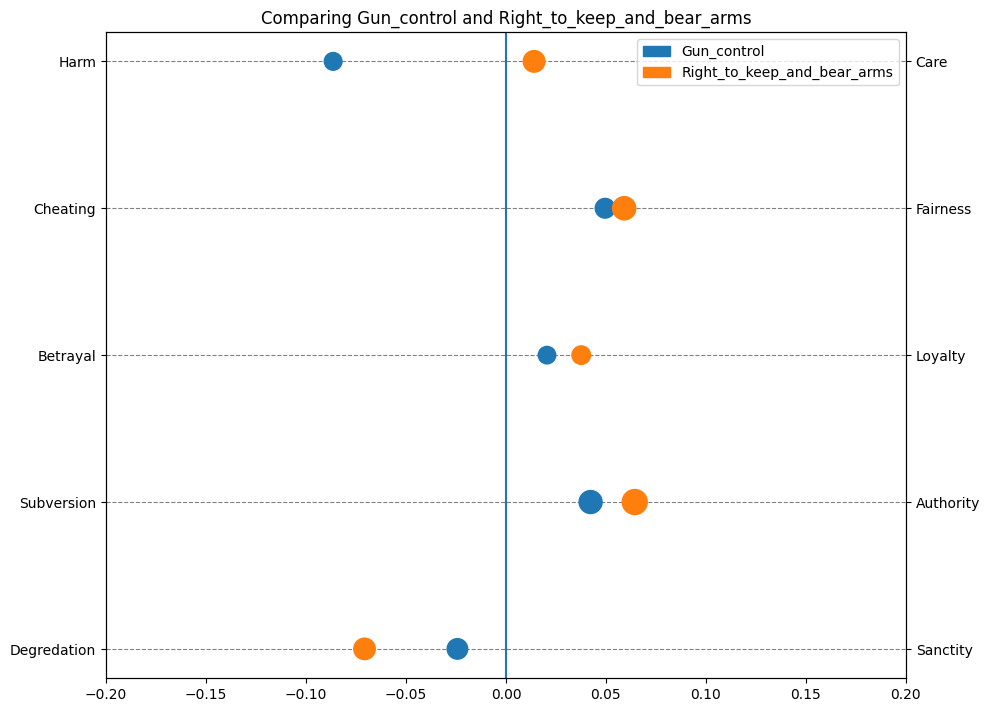

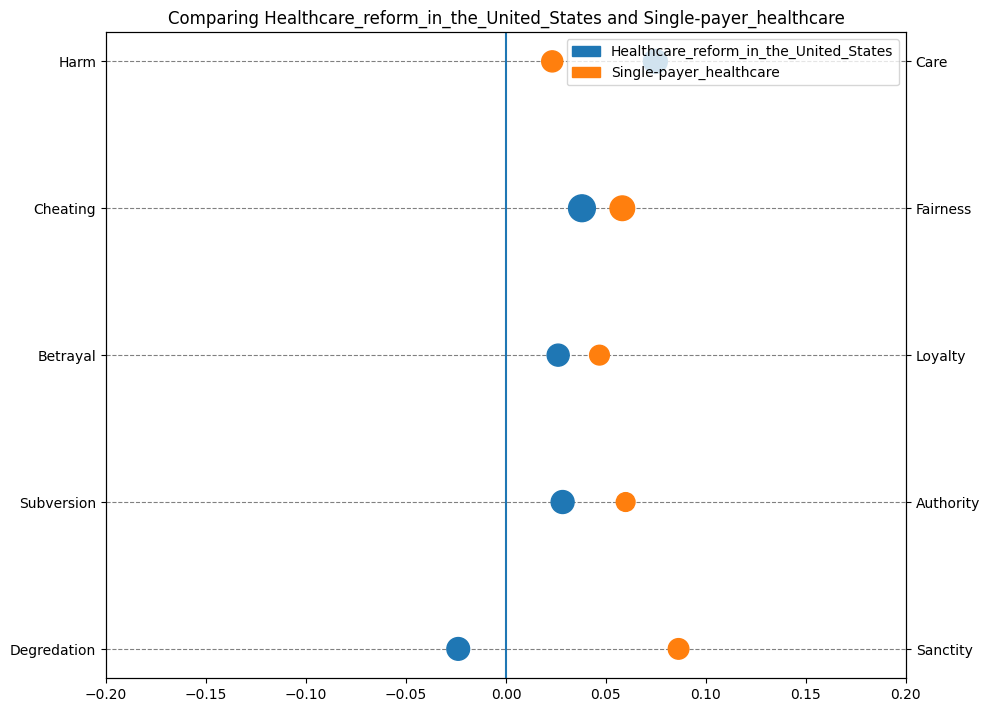

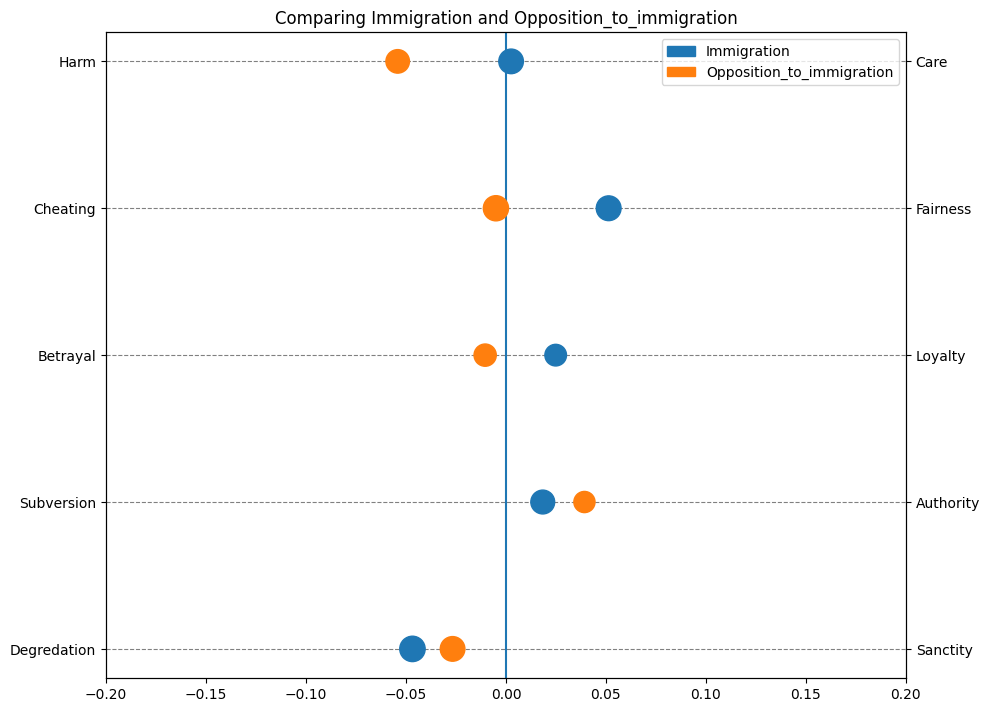

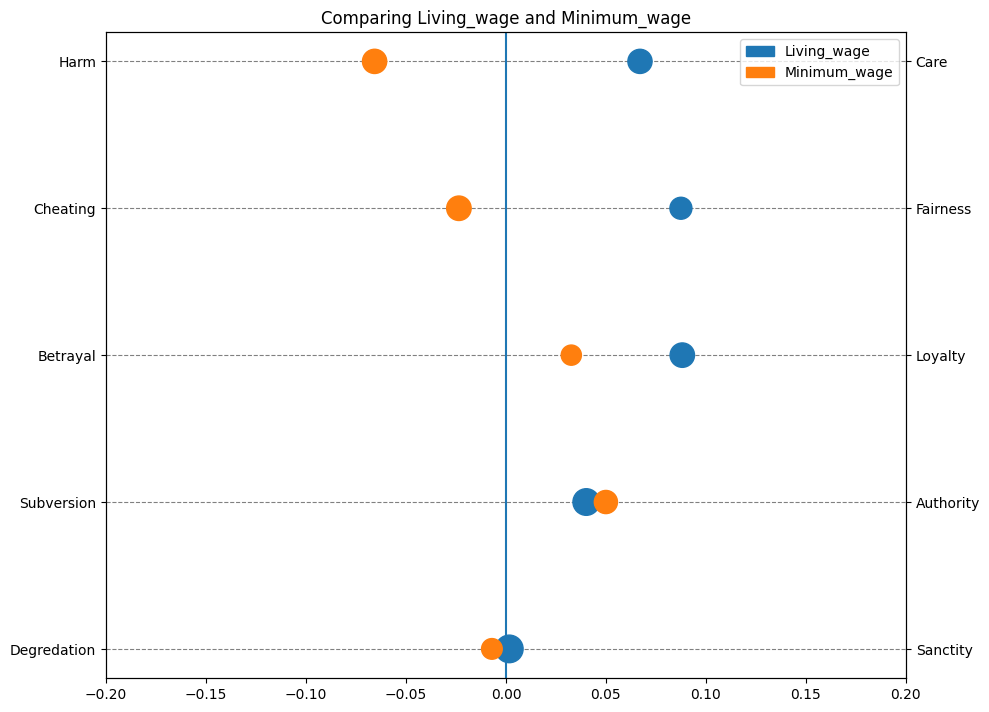

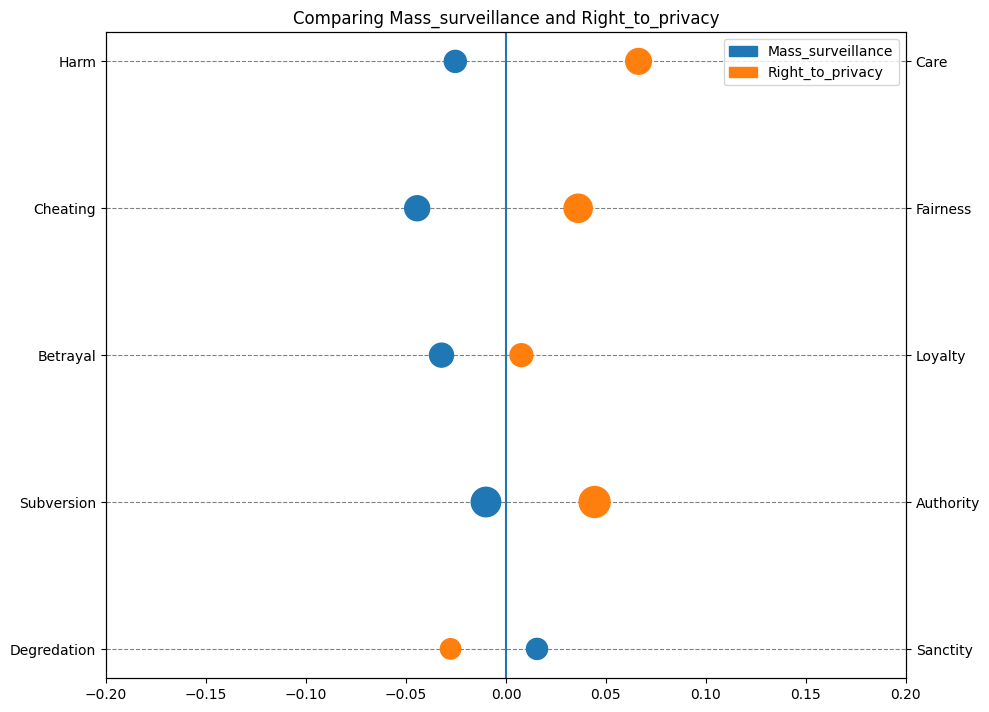

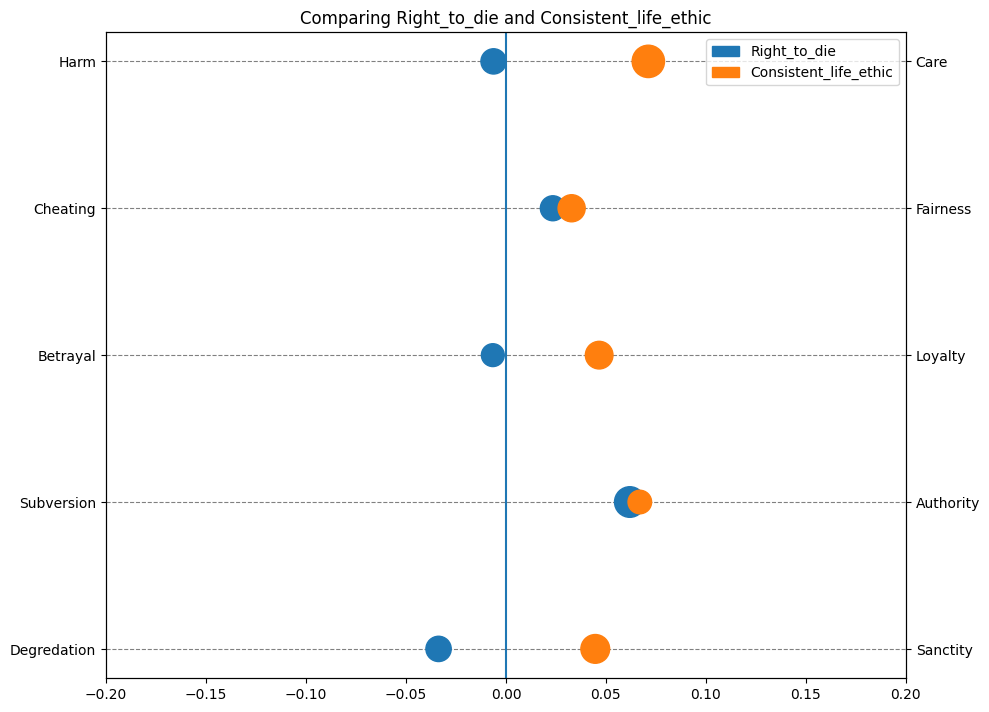

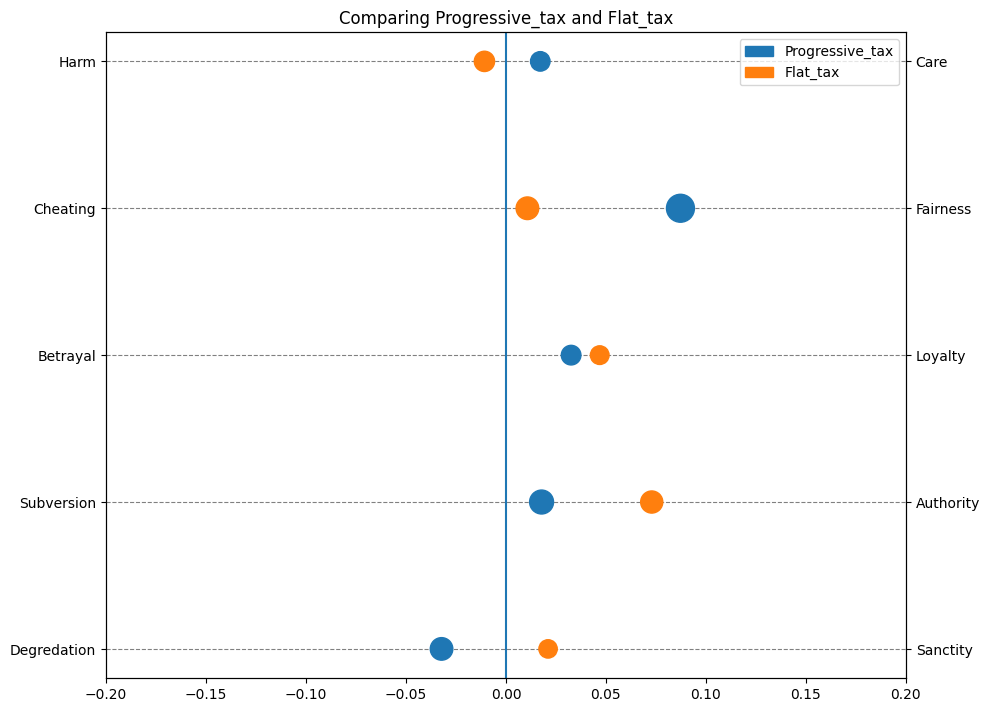

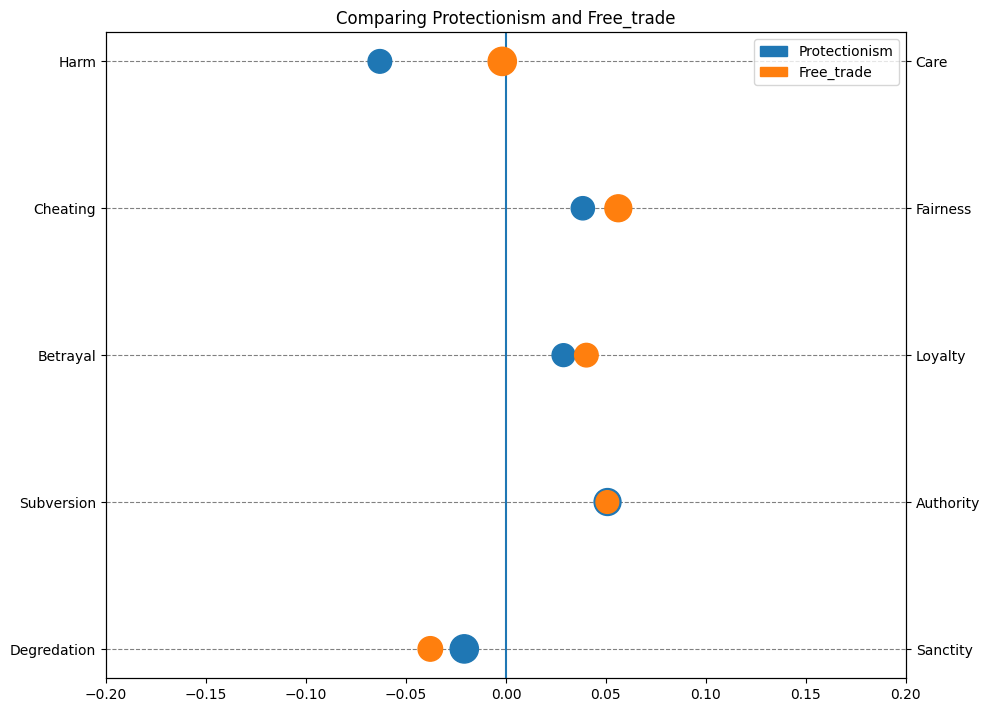

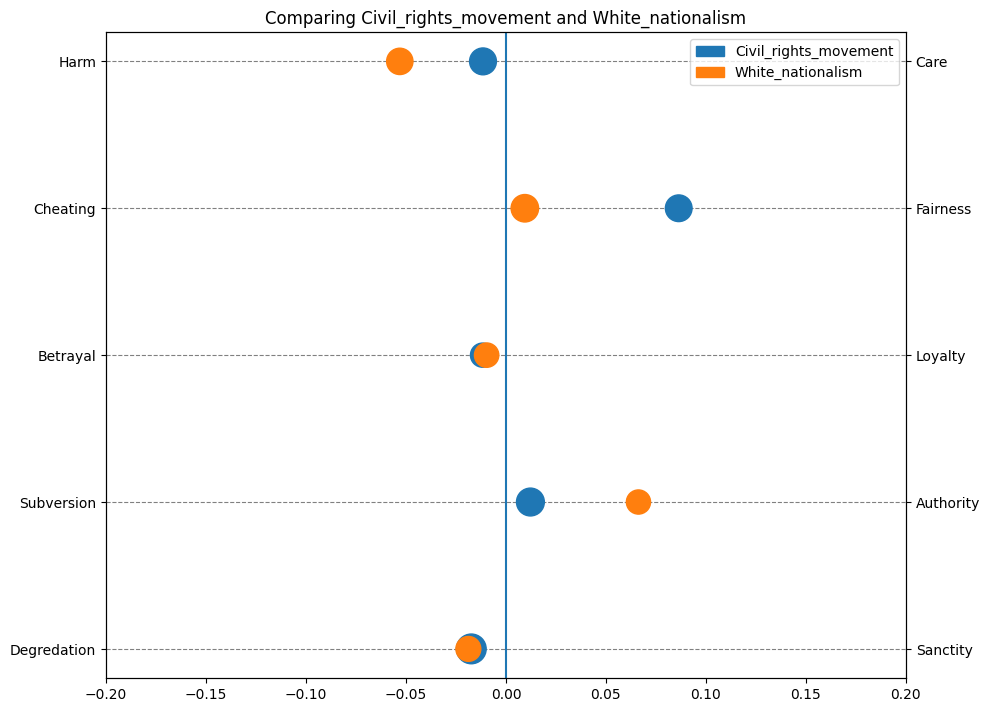

In [39]:
# left-liberal on the left, right-conservative on the right
opposing_views = [["Abortion-rights_movements", "Anti-abortion_movements"],
                   ["United_States_abortion-rights_movement", "United_States_anti-abortion_movement"],
                   ["Climate_change_mitigation", "Climate_change_denial"],
                   ["Gun_control", "Right_to_keep_and_bear_arms"],
                   ["Healthcare_reform_in_the_United_States","Single-payer_healthcare"], # todo
                   ["Immigration","Opposition_to_immigration"],
                   ["Living_wage", "Minimum_wage"], # todo
                   ["Mass_surveillance", "Right_to_privacy"], # neither left nor right
                   ["Right_to_die", "Consistent_life_ethic"],
                   ["Progressive_tax", "Flat_tax"],
                   ["Protectionism", "Free_trade"], # neither left nor right
                   ["Civil_rights_movement", "White_nationalism"]
                   ]
data_folder = "data/oppoing_views/frame_dimensions/"
plot_folder = "plots/opposing_views/frame_dimensions/"
os.makedirs(data_folder, exist_ok=True)
os.makedirs(plot_folder, exist_ok=True)
for article_pair in opposing_views:
    if load_from_file:
        df1 = pd.read_csv(data_folder + article_pair[0] + ".csv", header=[0, 1])
        df2 = pd.read_csv(data_folder + article_pair[1] + ".csv", header=[0, 1])
    else:
        articles = tokenize_articles(get_articles(article_pair))
        df1 = pd.DataFrame(framing_dimensions(articles[0]))
        df2 = pd.DataFrame(framing_dimensions(articles[1]))
        if save_to_file:
            df1.to_csv(data_folder + article_pair[0] + ".csv", index=False)
            df2.to_csv(data_folder + article_pair[1] + ".csv", index=False)
    g = compare_plots([df1, df2], article_pair)
    plt.title(f'Comparing {article_pair[0]} and {article_pair[1]}')
    if save_to_file:
        plt.savefig(plot_folder + article_pair[0] + "_" + article_pair[1] + ".png")
    plt.show()

In [ ]:
for category in categories:
    plot_folder = "plots/" + category + "/"
    g = visualize_boxplot(categories[category]["dfs"]) # ! not normalized by article length
    g.axes[0].set_axisbelow(True)
    g.axes[0].yaxis.grid(color="gray", linestyle="dashed")
    plt.xlim(-.2, .2) # ! arbitrary range
    plt.title(f'Aggregated Frame Dimensions for "{category}"')
    plt.gcf().set_size_inches(10, 7)
    if save_to_file:
        plt.savefig(plot_folder + "frame_dimensions/" + category + "_boxplots.png")
    plt.show()
if use_means:
    for category in categories:
        plot_folder = "plots/" + category + "/"
        g = visualize_boxplot(categories[category]["dfs"].mean())
        g.axes[0].set_axisbelow(True)
        g.axes[0].yaxis.grid(color="gray", linestyle="dashed")
        plt.xlim(-.2, .2) # ! arbitrary range
        plt.title(f'Aggregated Means for "{category}"')
        plt.gcf().set_size_inches(10, 7)
        if save_to_file:
            plt.savefig(plot_folder + "frame_dimensions/" + category + "_means_boxplots.png")
        plt.show()

In [ ]:
from framefinder import framelabels

candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
    "Other: any coherent group of frames not covered by the above categories",
]

framing_labels = framelabels.FramingLabels("facebook/bart-large-mnli", candidate_labels)

In [ ]:
for category in categories:
    articles = categories[category]["articles"]
    article_titles = categories[category]["article_titles"]
    plot_folder = "plots/" + category + "/"
    data_folder = "data/" + category + "/"
    os.makedirs(data_folder + "frame_labels", exist_ok=True)
    os.makedirs(plot_folder + "frame_labels", exist_ok=True)
    for i in range(len(articles)):
        if load_from_file:
            labels_df = pd.read_csv(data_folder + "frame_labels/" + article_titles[i] + ".csv")
            labels_df = labels_df.drop(columns=labels_df.columns[0])
        else:
            labels = framing_labels(articles[i])
            labels_df = pd.DataFrame(labels)
            if save_to_file:
                labels_df.to_csv(data_folder + "frame_labels/" + article_titles[i] + ".csv", index=False)
        _, ax = framing_labels.visualize(
            labels_df.mean().to_dict(), xerr=labels_df.sem()
        )
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
        plt.xticks([0.1, 0.5, 1])
        plt.title('Frame Labels for "' + article_titles[i] + '"')
        plt.axvline(0.5, color="red")
        if save_to_file:
            plt.savefig(plot_folder + "frame_labels/" + article_titles[i] + ".png")
        plt.show()

In [ ]:
texts = [ "Harm", "Care", "Authority", "Subversion", "Sanctity", "Degredation", "Loyalty", "Betrayal", "Fairness", "Cheating"]
plot_folder = "plots/moral_dimensions/"
texts = [ "You should get vaccinated because it is good for your health and the health of others.", 
         "You should get vaccinated because you might get sick and die if you don't.", 
         "You should get vaccinated because it is your right to be healthy.", 
         "You should get vaccinated because you don't want to be a threat to others.",
         "You should not get vaccinated because it is your right to decide what happens to your body.", 
         "You should not get vaccinated because it is your right to decide what happens to your body, even if it means you might get sick and die and spread the virus to others.", 
         "You should get vaccinated because the government says so.",
         "You should get vaccinated because it is your duty to society.", 
         "You should not get vaccinated because your religion forbids it.",
         "You should get vaccinated because the bible says that you should take care of your body and the bodies of others.",
         "You should get vaccinated because it is the only way to end the pandemic."]
plot_folder = "plots/test/"
texts = [ "liberalism", "conservatism", "libertarianism", "progressivism", "socialism", "leftism", "rightism", "centrism", "moderation", "radicalism"]
plot_folder = "plots/political_ideologies/"
os.makedirs(plot_folder + "frame_dimensions", exist_ok=True)
for i in range(len(texts)):
    dimensions = framing_dimensions(texts[i])
    dimensions_df = pd.DataFrame([dimensions])
    g = framing_dimensions.visualize(dimensions_df)
    g.axes[0].set_axisbelow(True)
    g.axes[0].yaxis.grid(color="gray", linestyle="dashed")
    plt.xlim(-.2, .2) # ! arbitrary range
    plt.title('Frame Dimensions for "' + texts[i] + '"')
    plt.gcf().set_size_inches(10, 7)
    if save_to_file:
        plt.savefig(plot_folder + "frame_dimensions/" + texts[i] + ".png")
    plt.show()